# KNN From Scratch
The point of this is to code a binary classifier KNN from scratch in order to learn the architecture, do some experimenting and feasibility checks. Useful for report material.

Will not be importing any modules and will be comptabile 8 bit ints. Although I will still have access to things like classes and lists, this will mimic the behaviour of the micro-processor better than otherwise.

I have used a lot more for loops than i usually would, this is mainly just to replicate.

## Sorting and counting functions

In [9]:
#chatgpted argsort which is needed
def mergesort(arr):
    if len(arr) <= 1:
        return arr

    mid = len(arr) // 2
    left = mergesort(arr[:mid])
    right = mergesort(arr[mid:])

    return merge(left, right)

def merge(left, right):
    result = []
    i = j = 0

    while i < len(left) and j < len(right):
        if left[i] < right[j]:
            result.append(left[i])
            i += 1
        else:
            result.append(right[j])
            j += 1

    result.extend(left[i:])
    result.extend(right[j:])
    return result

def argsort(arr):
    indices = list(range(len(arr)))  # Create a list of indices

    # Custom sorting function: Sort indices based on values in arr using mergesort
    def merge_sort_indices(indices):
        if len(indices) <= 1:
            return indices

        mid = len(indices) // 2
        left = merge_sort_indices(indices[:mid])
        right = merge_sort_indices(indices[mid:])

        return merge_indices(left, right)

    def merge_indices(left, right):
        result = []
        i = j = 0

        while i < len(left) and j < len(right):
            if arr[left[i]] < arr[right[j]]:  # Compare values from arr using indices
                result.append(left[i])
                i += 1
            else:
                result.append(right[j])
                j += 1

        result.extend(left[i:])
        result.extend(right[j:])
        return result

    return merge_sort_indices(indices)

def count(values):
    counter_0 = 0
    counter_1 = 0

    for val in values:
        if val == 0:
            counter_0 += 1
        else:
            counter_1 += 1

    if counter_1 > counter_0:
        return 1
    else:
        return 0 #but what if they are equal, need to come back to this


def distance(x1,x2):
    total = 0
    for c1,c2 in zip(x1,x2):
        total += (c2-c1)**2
    return total

## KNN

In [10]:
class KNN:#this will only do binary classification
    def __init__(self, K):#might add weighting later but just uniform for the time being
        """Would recommend K is odd only based on how the counting in prediction is done."""
        self.K = K

    def fit(self,x,y):
        self.x = x
        self.y = y

    def predict(self, input_points):
        """
        The assembly version does not need to be written like this as we will
        pass it events one by one but it helps for testing in python.
        """
        results = []
        for point in input_points:
            results.append(self.predict_point(point))

        return results

    def predict_point(self, input_point):
        #going to calculate distance to everypoint and then sort, will upgrade this later
        distances = [distance(x, input_point) for x in self.x]
        points = self.y[argsort(distances)[:self.K]]
        return count(points)


    #these methods will NOT be in the assembly version but is useful for testing purposes
    def score(self, x, y):
        predictions = self.predict(x)
        counter = 0
        for pred, label in zip(predictions, y):
            if pred == label:
                counter += 1

        return counter/len(y)
            
    def get_params(self,deep):
        return {"K":self.K}
        
        


## Cross-validation



having some odd behaviour from cross_val_score, going to write use this one from chatgpt

In [19]:
import numpy as np

def k_fold_cross_validation(model, X, y, k=5, metric=None):
    """
    Perform k-fold cross-validation.
    
    Parameters:
    model: an object with fit(X_train, y_train) and predict(X_test) methods
    X: numpy array or list, feature matrix
    y: numpy array or list, target vector
    k: int, number of folds (default is 5)
    metric: function, performance metric (default is accuracy)
    
    Returns:
    scores: list of performance scores for each fold
    """
    if metric is None:
        metric = lambda y_true, y_pred: np.mean(y_true == y_pred)  # Default to accuracy
    
    X, y = np.array(X), np.array(y)
    indices = np.arange(len(X))
    np.random.shuffle(indices)  # Shuffle data indices
    
    fold_size = len(X) // k
    scores = []
    
    for i in range(k):
        test_indices = indices[i * fold_size:(i + 1) * fold_size]
        train_indices = np.concatenate((indices[:i * fold_size], indices[(i + 1) * fold_size:]))
        
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]
        
        model.fit(X_train, y_train)  # Train model
        y_pred = model.predict(X_test)  # Predict
        
        score = metric(y_test, y_pred)
        scores.append(score)
    
    return scores

## testing rq
from sklearn.neighbors import KNeighborsClassifier

waveforms_data = np.load("nf_waveforms_dset.npy", allow_pickle=True).item()

X = waveforms_data['data']
y = waveforms_data['target']

model1 = KNeighborsClassifier(5)
model2 = KNN(5)

print(np.mean(k_fold_cross_validation(model1, X, y)))
print(np.mean(k_fold_cross_validation(model2, X, y)))


0.9199999999999999
0.9199999999999999


## Performance Testing 1

Just a quick test to see how it behaves.

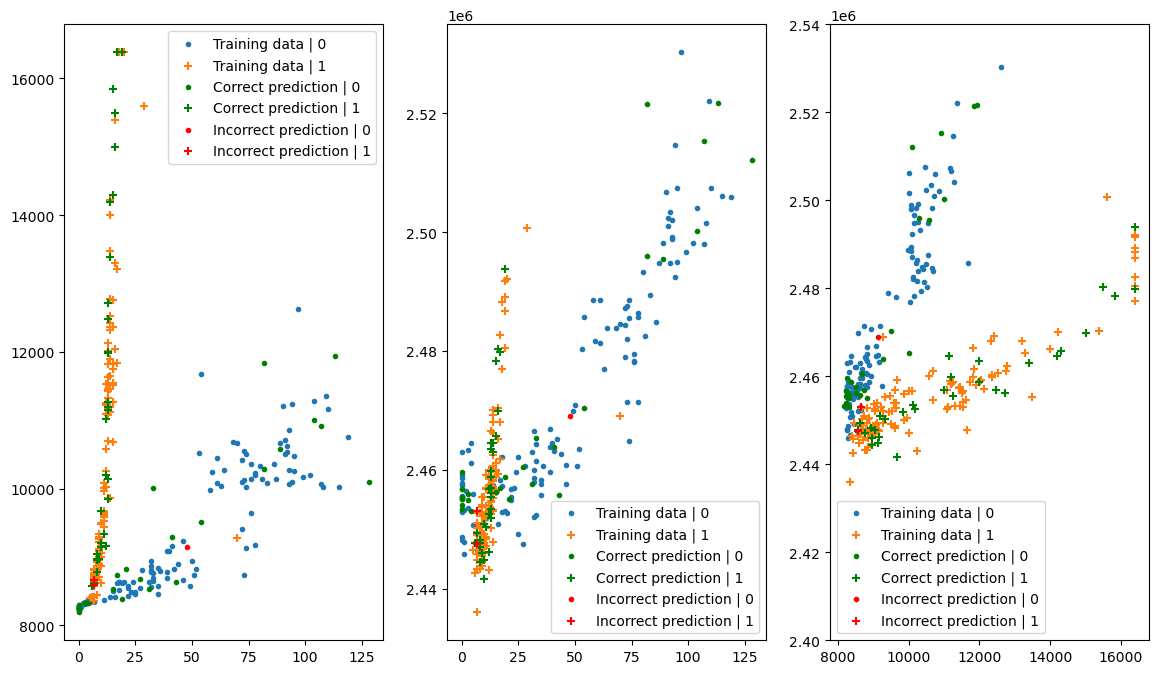

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import numpy as np

waveforms_data = np.load("nf_waveforms_dset.npy", allow_pickle=True).item()

X = waveforms_data['data']
y = waveforms_data['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

model = KNN(1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

correct_data = X_test[predictions==y_test]
correct_labels = y_test[predictions==y_test]
incorrect_data = X_test[predictions!=y_test]
incorrect_labels = y_test[predictions!=y_test]

fig, ax = plt.subplots(1,3, figsize=(14,8))

ax[0].scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,1], marker = ".", label = "Training data | 0")
ax[0].scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], marker = "+", label = "Training data | 1")

ax[0].scatter(correct_data[correct_labels==0][:,0], correct_data[correct_labels==0][:,1], marker = ".", label = "Correct prediction | 0", color="Green")
ax[0].scatter(correct_data[correct_labels==1][:,0], correct_data[correct_labels==1][:,1], marker = "+", label = "Correct prediction | 1", color="Green")

ax[0].scatter(incorrect_data[incorrect_labels==0][:,0], incorrect_data[incorrect_labels==0][:,1], marker = ".", label = "Incorrect prediction | 0", color="red")
ax[0].scatter(incorrect_data[incorrect_labels==1][:,0], incorrect_data[incorrect_labels==1][:,1], marker = "+", label = "Incorrect prediction | 1", color="red")


ax[1].scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,2], marker = ".", label = "Training data | 0")
ax[1].scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,2], marker = "+", label = "Training data | 1")

ax[1].scatter(correct_data[correct_labels==0][:,0], correct_data[correct_labels==0][:,2], marker = ".", label = "Correct prediction | 0", color="Green")
ax[1].scatter(correct_data[correct_labels==1][:,0], correct_data[correct_labels==1][:,2], marker = "+", label = "Correct prediction | 1", color="Green")

ax[1].scatter(incorrect_data[incorrect_labels==0][:,0], incorrect_data[incorrect_labels==0][:,2], marker = ".", label = "Incorrect prediction | 0", color="red")
ax[1].scatter(incorrect_data[incorrect_labels==1][:,0], incorrect_data[incorrect_labels==1][:,2], marker = "+", label = "Incorrect prediction | 1", color="red")


ax[2].scatter(X_train[y_train==0][:,1], X_train[y_train==0][:,2], marker = ".", label = "Training data | 0")
ax[2].scatter(X_train[y_train==1][:,1], X_train[y_train==1][:,2], marker = "+", label = "Training data | 1")

ax[2].scatter(correct_data[correct_labels==0][:,1], correct_data[correct_labels==0][:,2], marker = ".", label = "Correct prediction | 0", color="Green")
ax[2].scatter(correct_data[correct_labels==1][:,1], correct_data[correct_labels==1][:,2], marker = "+", label = "Correct prediction | 1", color="Green")

ax[2].scatter(incorrect_data[incorrect_labels==0][:,1], incorrect_data[incorrect_labels==0][:,2], marker = ".", label = "Incorrect prediction | 0", color="red")
ax[2].scatter(incorrect_data[incorrect_labels==1][:,1], incorrect_data[incorrect_labels==1][:,2], marker = "+", label = "Incorrect prediction | 1", color="red")

ax[2].set_ylim((2.40e6, 2.54e6))

ax[0].legend()
ax[1].legend()
ax[2].legend()


Going to scan for best K value

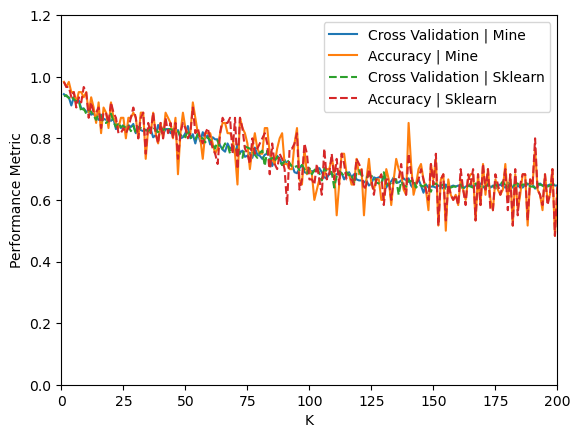

In [18]:
max_ks = 200
ks = np.linspace(1,max_ks,max_ks)
cross_scores = []
acc_scores = []

cross_scores_sklearn = []
acc_scores_sklearn = []

for k in ks:
    model = KNN(int(k))
    model.fit(X,y)
    cross_scores.append(np.mean(k_fold_cross_validation(model, X, y)))

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
    acc_scores.append(model.score(X_test, y_test))


    model = KNeighborsClassifier(int(k))
    model.fit(X,y)
    cross_scores_sklearn.append(np.mean(k_fold_cross_validation(model, X, y)))

    acc_scores_sklearn.append(model.score(X_test, y_test))


fig, ax = plt.subplots(1,1)
ax.plot(ks,cross_scores, label="Cross Validation | Mine")
ax.plot(ks,acc_scores, label="Accuracy | Mine")

ax.plot(ks,cross_scores_sklearn, label="Cross Validation | Sklearn", linestyle='--')
ax.plot(ks,acc_scores_sklearn, label="Accuracy | Sklearn", linestyle='--')


ax.set_xlabel("K")
ax.set_ylabel("Performance Metric")
ax.set_xlim((0,200))
ax.set_ylim((0,1.2))
ax.legend()


## Rescaling Data
Need to scale it to be in 8 bits ints

In [13]:
waveforms_data = np.load("nf_waveforms_dset.npy", allow_pickle=True).item()

X = waveforms_data['data']
y = waveforms_data['target']

def scale_and_cast(data):
    for i in range(0,data.shape[1]):
        sf = 255/(max(data[:,i]) - min(data[:,i]))
        data[:,i] = (data[:,i] - min(data[:,i])) * sf

    return np.rint(data)

scale_and_cast(X)

array([[102.,  17.,  67.],
       [ 88.,  22.,  72.],
       [ 36.,  10.,  71.],
       [ 50.,   9.,  71.],
       [ 30.,  10.,  55.],
       [ 32.,   7.,  40.],
       [ 46.,   9.,  57.],
       [ 44.,  11.,  56.],
       [ 36.,  14.,  57.],
       [100.,  24.,  94.],
       [  6.,   4.,  54.],
       [  6.,   4.,  48.],
       [  0.,   2.,  58.],
       [  8.,   4.,  68.],
       [  2.,   3.,  47.],
       [  0.,   2.,  46.],
       [  0.,   3.,  61.],
       [  6.,   4.,  51.],
       [177.,  77., 168.],
       [183.,  76., 182.],
       [  8.,   4.,  46.],
       [  0.,   2.,  59.],
       [ 64.,  23.,  65.],
       [ 84.,  20.,  79.],
       [ 96.,  30.,  89.],
       [ 92.,  15.,  67.],
       [ 78.,  19.,  75.],
       [ 40.,  14.,  45.],
       [ 82.,  34.,  75.],
       [108.,  41.,  93.],
       [ 64.,  19.,  83.],
       [ 34.,  13.,  60.],
       [181.,  78., 176.],
       [  4.,   4.,  55.],
       [116.,  55., 142.],
       [  0.,   2.,  52.],
       [  0.,   2.,  64.],
 

## Performance Testing 2

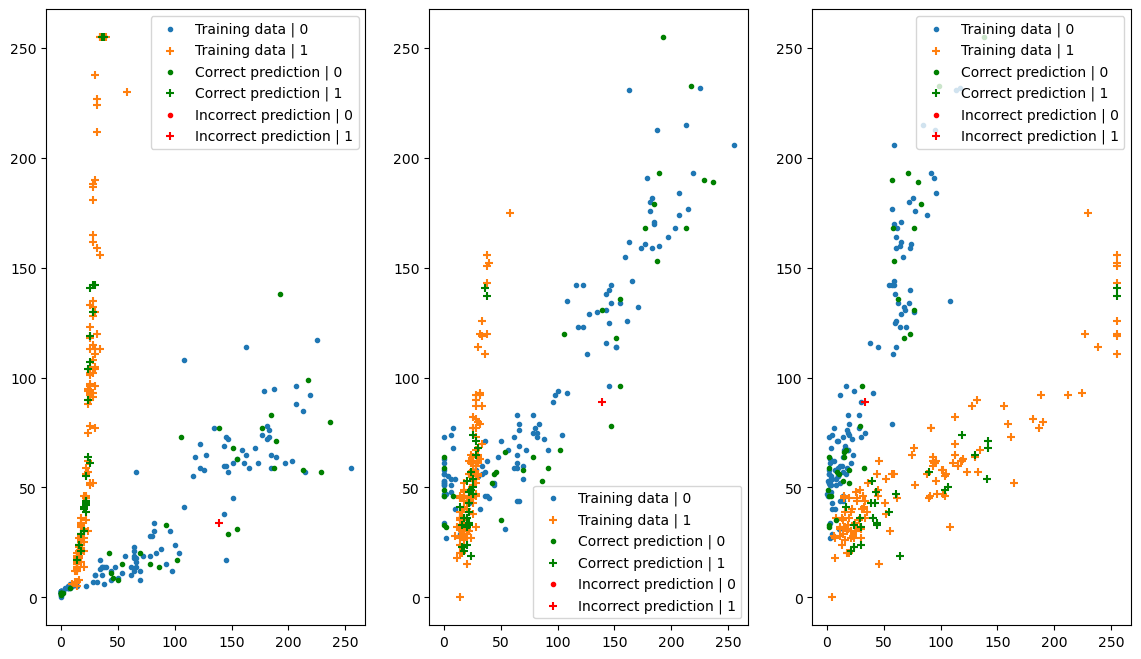

In [14]:
waveforms_data = np.load("nf_waveforms_dset.npy", allow_pickle=True).item()

X = scale_and_cast(waveforms_data['data'])
y = waveforms_data['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

model = KNN(1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

correct_data = X_test[predictions==y_test]
correct_labels = y_test[predictions==y_test]
incorrect_data = X_test[predictions!=y_test]
incorrect_labels = y_test[predictions!=y_test]

fig, ax = plt.subplots(1,3, figsize=(14,8))

ax[0].scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,1], marker = ".", label = "Training data | 0")
ax[0].scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], marker = "+", label = "Training data | 1")

ax[0].scatter(correct_data[correct_labels==0][:,0], correct_data[correct_labels==0][:,1], marker = ".", label = "Correct prediction | 0", color="Green")
ax[0].scatter(correct_data[correct_labels==1][:,0], correct_data[correct_labels==1][:,1], marker = "+", label = "Correct prediction | 1", color="Green")

ax[0].scatter(incorrect_data[incorrect_labels==0][:,0], incorrect_data[incorrect_labels==0][:,1], marker = ".", label = "Incorrect prediction | 0", color="red")
ax[0].scatter(incorrect_data[incorrect_labels==1][:,0], incorrect_data[incorrect_labels==1][:,1], marker = "+", label = "Incorrect prediction | 1", color="red")


ax[1].scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,2], marker = ".", label = "Training data | 0")
ax[1].scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,2], marker = "+", label = "Training data | 1")

ax[1].scatter(correct_data[correct_labels==0][:,0], correct_data[correct_labels==0][:,2], marker = ".", label = "Correct prediction | 0", color="Green")
ax[1].scatter(correct_data[correct_labels==1][:,0], correct_data[correct_labels==1][:,2], marker = "+", label = "Correct prediction | 1", color="Green")

ax[1].scatter(incorrect_data[incorrect_labels==0][:,0], incorrect_data[incorrect_labels==0][:,2], marker = ".", label = "Incorrect prediction | 0", color="red")
ax[1].scatter(incorrect_data[incorrect_labels==1][:,0], incorrect_data[incorrect_labels==1][:,2], marker = "+", label = "Incorrect prediction | 1", color="red")


ax[2].scatter(X_train[y_train==0][:,1], X_train[y_train==0][:,2], marker = ".", label = "Training data | 0")
ax[2].scatter(X_train[y_train==1][:,1], X_train[y_train==1][:,2], marker = "+", label = "Training data | 1")

ax[2].scatter(correct_data[correct_labels==0][:,1], correct_data[correct_labels==0][:,2], marker = ".", label = "Correct prediction | 0", color="Green")
ax[2].scatter(correct_data[correct_labels==1][:,1], correct_data[correct_labels==1][:,2], marker = "+", label = "Correct prediction | 1", color="Green")

ax[2].scatter(incorrect_data[incorrect_labels==0][:,1], incorrect_data[incorrect_labels==0][:,2], marker = ".", label = "Incorrect prediction | 0", color="red")
ax[2].scatter(incorrect_data[incorrect_labels==1][:,1], incorrect_data[incorrect_labels==1][:,2], marker = "+", label = "Incorrect prediction | 1", color="red")


ax[0].legend()
ax[1].legend()
ax[2].legend()

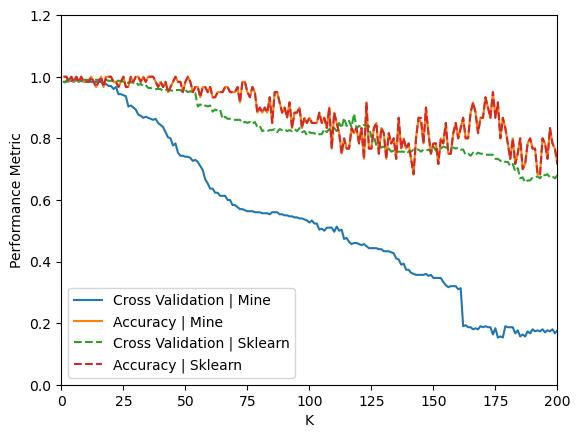

In [15]:
max_ks = 200
ks = np.linspace(1,max_ks,max_ks)
cross_scores = []
acc_scores = []

cross_scores_sklearn = []
acc_scores_sklearn = []

for k in ks:
    model = KNN(int(k))
    model.fit(X,y)
    cross_scores.append(np.mean(cross_val_score(model, X, y)))

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
    acc_scores.append(model.score(X_test, y_test))

    model = KNeighborsClassifier(int(k))
    model.fit(X,y)
    cross_scores_sklearn.append(np.mean(cross_val_score(model, X, y)))

    acc_scores_sklearn.append(model.score(X_test, y_test))


fig, ax = plt.subplots(1,1)
ax.plot(ks,cross_scores, label="Cross Validation | Mine")
ax.plot(ks,acc_scores, label="Accuracy | Mine")

ax.plot(ks,cross_scores_sklearn, label="Cross Validation | Sklearn", linestyle='--')
ax.plot(ks,acc_scores_sklearn, label="Accuracy | Sklearn", linestyle='--')


ax.set_xlabel("K")
ax.set_ylabel("Performance Metric")
ax.set_xlim((0,200))
ax.set_ylim((0,1.2))
ax.legend()